#### Distributions of expression levels for known and novel UTRons in all bladder cancer samples 

In [1]:
import sqlite3
import pandas as pd
import numpy as np


cnx = sqlite3.connect('/shared/sudlab1/General/projects/utrons_project/BladderCancerUtrons/431BladderUtrons.db')
cnx.execute("ATTACH '/shared/sudlab1/General/annotations/hg38_noalt_ensembl85/csvdb' as annotations")

Get novel and known ids into seperate databases

In [3]:
# Get novel tx ids
query_text1 = """
    SELECT uid.transcript_id AS name, ti.gene_name AS gene
    FROM novel_utrons_ids AS uid
    INNER JOIN annotations.transcript_info AS ti
    ON ti.transcript_id = uid.match_transcript_id
    WHERE uid.transcript_id like "MSTRG%" AND uid.track="agg-agg-agg"
    ORDER BY uid.transcript_id
    """
novelUtronIds = pd.read_sql_query(query_text1, cnx)


# Get known tx ids
query_text1 = """
    SELECT uid.transcript_id AS name, ti.gene_name AS gene
    FROM all_utrons_ids AS uid
    INNER JOIN transcript_class AS tc
    ON tc.transcript_id = uid.transcript_id
    INNER JOIN annotations.transcript_info AS ti
    ON ti.transcript_id = tc.match_transcript_id
    WHERE uid.transcript_id like "ENS%" AND tc.track="agg-agg-agg"
    GROUP BY uid.transcript_id
    ORDER BY uid.transcript_id
    """
allUtronIds = pd.read_sql_query(query_text1, cnx)

Get the proportion of genes at each tpm threshold for each sample into a dataframe

    (e.g.) tpm   sample1_proportion      sample2_proportion     sample3_proportion

In [5]:
# Range of tpms to loop through
tpmRange = range(0,500,1)


# Function gets the  proportions of utron genes which are present at each tpm threshold
def getDistributions(sample):
    
    # File with the salmon quantification info
    filename = "/shared/sudlab1/General/projects/utrons_project/BladderCancerUtrons/Quantifications/%s_agg-agg-agg.sf" % sample
    sampleTpms = pd.read_csv(filename, sep="\t")
    
    #Filter to get novel/all utrons into a dataframe
    novelTpms = pd.merge(sampleTpms, novelUtronIds, left_on="Name", right_on="name")
    allTpms = pd.merge(sampleTpms, allUtronIds, left_on="Name", right_on="name")
    
    novelDistributions = []
    allDistributions = []
    numNovel = len(novelTpms)
    numAll = len(allTpms)
    
    # Get proportions at a range of tpms (from 0 -> 500)
    for tpm in tpmRange:
        # Get novel Utron proportions
        number = len(novelTpms[novelTpms["TPM"] <= tpm ])
        proportion = float(number) / numNovel
        novelDistributions.append(proportion)
        
        # Get all Utron Proportions
        number = len(allTpms[allTpms["TPM"] <= tpm ])
        proportion = float(number) / numAll
        allDistributions.append(proportion)
        
    return novelDistributions, allDistributions
    
# Create initial array using ZF-WT-1
novelProportions,allProportions  = getDistributions("ZF-WT-1")

# Loop through rest of samples
for num in range(2,432,1):
    if num != 252 and num != 347:
        sample = "ZF-WT-%d" % num
        a, b= getDistributions(sample)
        
        # append proportions to their respective array
        novelProportions = np.column_stack([novelProportions, a])
        allProportions = np.column_stack([allProportions, b])

Average proportions across all samples

In [6]:
# Number of samples used
numSamples = len(novelProportions[0, :])


# Lists to hold averages
novelAverages = []
allAverages = []

# Loop through each tpm in the tpmrange set previously and average to the proportions
for tpm in tpmRange:
    # get novel averages
    novelAverage = sum(novelProportions[tpm, :]) / numSamples
    novelAverages.append(novelAverage)
    
    # get all averages
    allAverage = sum(allProportions[tpm, :]) / numSamples
    allAverages.append(allAverage)

Populating the interactive namespace from numpy and matplotlib


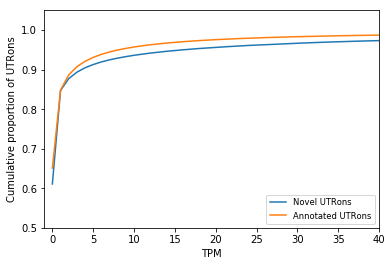

In [8]:

# Plot graphs for novel and known utron distribtuons
%pylab inline

#Plot Vals
pylab.plot(tpmRange, novelAverages, label="Novel UTRons")
pylab.plot(tpmRange, allAverages, label="Annotated UTRons")

# Plot Options
pylab.xlim(-1,40)
pylab.ylim(0.5,1.05)
pylab.ylabel("Cumulative proportion of UTRons"); pylab.xlabel("TPM")
pylab.legend(fontsize="small", loc=4)
pylab.savefig("./images/2_ExpressionDistributions", dpi=300)

In [14]:
print "percent between 0 - 1 tpm for novel and known"
print novelAverages[1] - novelAverages[0]
print allAverages[1] - allAverages[0]

print "\npercent between 0 - 5 tpm for novel and known"
print novelAverages[5] - novelAverages[0]
print allAverages[5] - allAverages[0]

print "\npercent with 0 quantification"
print novelAverages[0]
print allAverages[0]

percent between 0 - 1 tpm for novel and known
0.236457545157
0.197193348112

percent between 0 - 5 tpm for novel and known
0.302095576184
0.279907222164

percent with 0 quantification
0.610877429399
0.651153842755
